### Target:

- Add GAP and remove 7*7 Conv at the end

### Results:

- Parameters: 6070
- Best Training Accuracy: 98.81
- Best Test Accuracy: 98.72

### Analysis:
- Due to reduction in parameter from 10k in previous exp. t0 6k causes falls in accuracy.
- Also GAP is not impacting in fall in accuracy
- No Overfitting seen except last layer
- In next experiment we will increase capacity in such a way that parameters are below 8k and accuracy is 99.2+


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session7'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session7', '/content/drive/MyDrive/Colab_Notebooks/Session7']


# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1325,), (0.3105,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [19]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


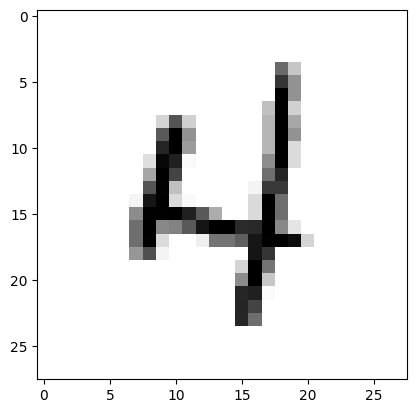

In [20]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [21]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [7]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)
exp_data = exp.test_data
exp_data = exp.transform(exp_data.numpy())

print('[Test]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

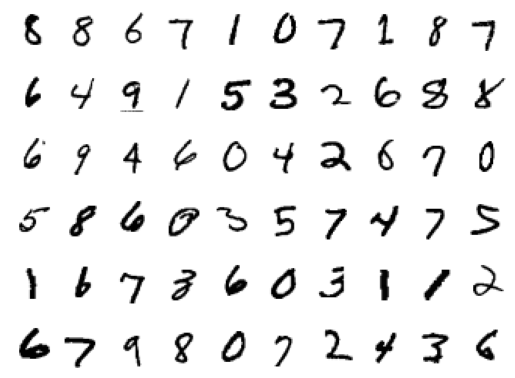

In [23]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [24]:
from models import Model6 as Net ,get_summary

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [25]:
device = torch.device("cuda" if cuda else "cpu")
model =  Net(dropout_value=0.1).to(device)
get_summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1, 10,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [26]:
from tqdm import tqdm
from utils import train,test
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Let's Train and test our model

In [27]:
model =  Net(dropout_value=0.1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc_temp,train_losses_temp   = train(model, device, train_loader, optimizer, epoch,None)
    test_acc_temp,test_losses_temp = test(model, device, test_loader)
    train_acc.extend(train_acc_temp)
    train_losses.extend(train_losses_temp)
    test_acc.extend(test_acc_temp)
    test_losses.extend(test_losses_temp)

EPOCH: 0


Loss=0.34379053115844727 Batch_id=468 Accuracy=83.11: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]



Test set: Average loss: 0.2871, Accuracy: 9561/10000 (95.61%)

EPOCH: 1


Loss=0.138944610953331 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]



Test set: Average loss: 0.2381, Accuracy: 9455/10000 (94.55%)

EPOCH: 2


Loss=0.10513726621866226 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]



Test set: Average loss: 0.1277, Accuracy: 9742/10000 (97.42%)

EPOCH: 3


Loss=0.12253887206315994 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]



Test set: Average loss: 0.1168, Accuracy: 9748/10000 (97.48%)

EPOCH: 4


Loss=0.06950297206640244 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]



Test set: Average loss: 0.0797, Accuracy: 9826/10000 (98.26%)

EPOCH: 5


Loss=0.0916263684630394 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]



Test set: Average loss: 0.1734, Accuracy: 9519/10000 (95.19%)

EPOCH: 6


Loss=0.07139870524406433 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]



Test set: Average loss: 0.0631, Accuracy: 9846/10000 (98.46%)

EPOCH: 7


Loss=0.12047239392995834 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.0786, Accuracy: 9812/10000 (98.12%)

EPOCH: 8


Loss=0.06802412867546082 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]



Test set: Average loss: 0.0703, Accuracy: 9849/10000 (98.49%)

EPOCH: 9


Loss=0.06215989217162132 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]



Test set: Average loss: 0.0592, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Loss=0.03603147342801094 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0602, Accuracy: 9852/10000 (98.52%)

EPOCH: 11


Loss=0.07261043787002563 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]



Test set: Average loss: 0.0601, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.0807841420173645 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]



Test set: Average loss: 0.0478, Accuracy: 9883/10000 (98.83%)

EPOCH: 13


Loss=0.09676869958639145 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]



Test set: Average loss: 0.0546, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Loss=0.029104577377438545 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]



Test set: Average loss: 0.0503, Accuracy: 9872/10000 (98.72%)



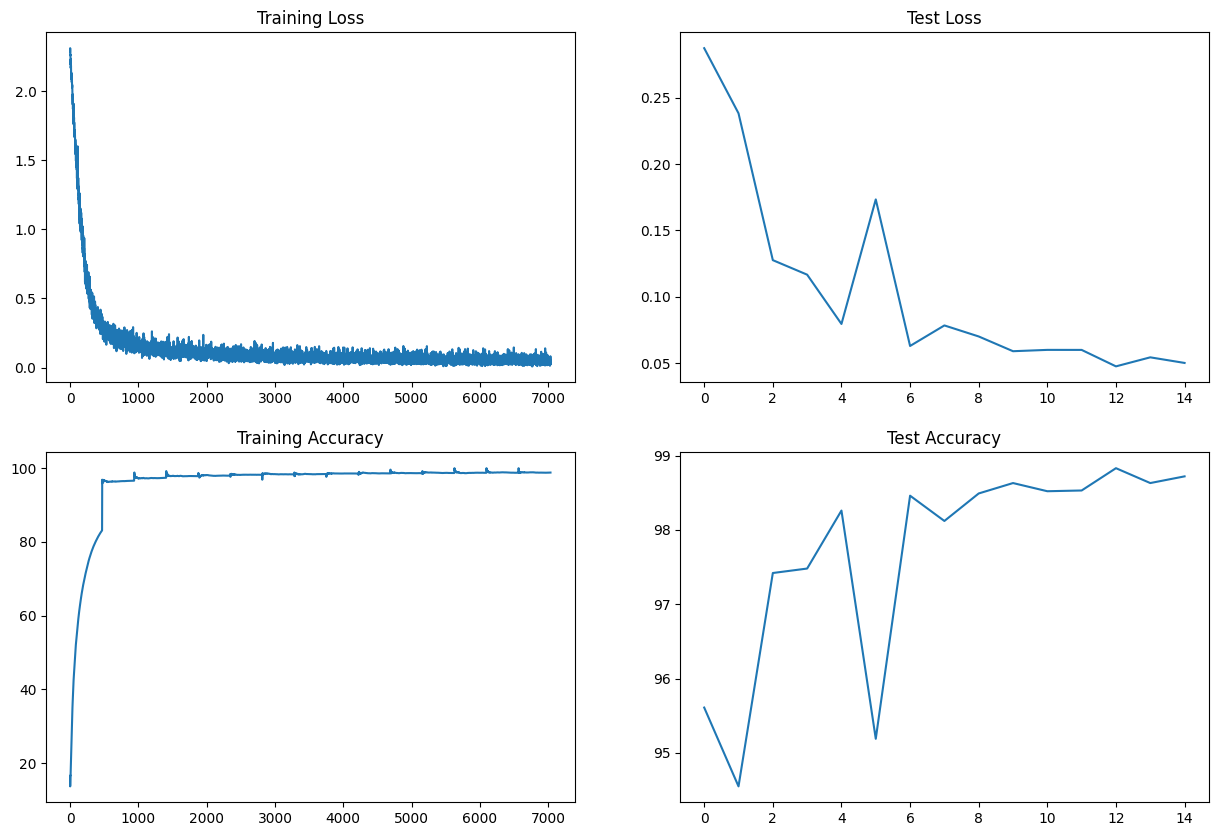

In [28]:
from utils import plot_accuracy_losses,train,test
plot_accuracy_losses(train_losses,train_acc,test_losses,test_acc)

In [29]:
print(train_acc)
print(train_losses)
print(test_acc)
print(test_losses)

[16.40625, 13.671875, 14.0625, 15.8203125, 16.5625, 16.666666666666668, 16.629464285714285, 16.796875, 18.229166666666668, 18.046875, 18.821022727272727, 19.53125, 20.432692307692307, 20.703125, 21.614583333333332, 22.55859375, 23.4375, 24.21875, 25.370065789473685, 25.8984375, 26.5625, 27.166193181818183, 27.547554347826086, 28.092447916666668, 28.875, 29.417067307692307, 30.06365740740741, 30.580357142857142, 31.25, 32.005208333333336, 32.560483870967744, 33.10546875, 33.73579545454545, 34.35202205882353, 34.888392857142854, 35.221354166666664, 35.68412162162162, 36.348684210526315, 36.83894230769231, 37.32421875, 37.86204268292683, 38.448660714285715, 38.93531976744186, 39.29332386363637, 39.6875, 40.06453804347826, 40.6748670212766, 40.901692708333336, 41.214923469387756, 41.625, 42.23345588235294, 42.51802884615385, 42.74764150943396, 43.04108796296296, 43.32386363636363, 43.680245535714285, 44.02412280701754, 44.3292025862069, 44.58421610169491, 45.013020833333336, 45.35092213114